# Hosted GCP Fraud Detection Example
In this Colab notebook, we will leverage GCP to detect fraudulent transactions. 

We'll cover using: 

*   Featureform ➡️ Feature Store & Feature Serving
*   Scikitlearn ➡️ Model Training
*   Training/Offline Store: BigQuery
*   Inference/Online Store: Firestore   


For more information about providers, writing transformations, etc please check out our docs: 
* [Docs](https://docs.featureform.com/)

---


## 🎯 `Most Important Takeaways`

Specifically you'll see examples of:

*   ✅ How to connect to providers like BigQuery & Firestore

*   ✅ How to connect to a table as a source 

*   ✅ Writing transformations using sql transformations


*   ✅ Creating different variants of features & training sets & zipping them up 

*   ✅ "Write once, serve twice" - Serving features for training & for production inference is as simple as providing a key & specifying whichh model & set of features you'd like to use for specific entities 

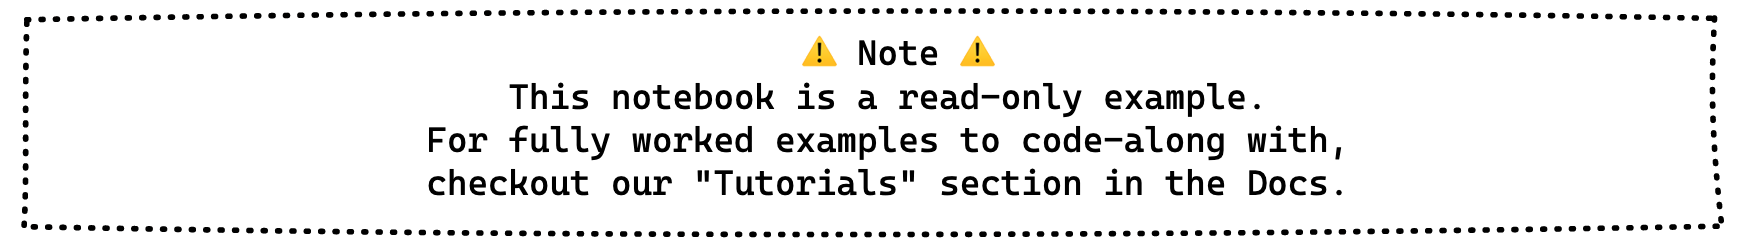

## 🚨 Prerequisites

1.   GCP Account
2.   [GCP Featureform Quickstart](https://docs.featureform.com/quickstart-gcp) (Steps 1-6)
3.   [Transaction Data loaded in BigQuery](https://docs.featureform.com/quickstart-gcp#step-6-load-demo-data)
4.   GCP credentials file for access to Firestore & BigQuery


### Mount the Google Drive

The Google Drive will be used to access the credential files for Firestore & BigQuery. Make sure you have your credentials file in your drive under *credentials* folder. You will be asked to give access to mount your drive. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Verify that the credential files are accessible

In [ ]:
!ls ./drive/<path-to-your>/credentials/

aws_info.env  azure_redisent.env      bigquery.json
azure.env     azure_redis_paired.env  firestore.json


### Check Demo Dashboard

👉🏻 [Featureform Dashboard](http://gcp.featureform.com/)

# 📋 Getting Setup

## Install & Import Featureform

In [ ]:
!pip3 -q install featureform

import featureform as ff

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 KB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 KB 24.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 KB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 KB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 11.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.22.0 which is incompatible.
tensorflow-metadata 1.12.0 requires protobuf<4,>=3.13, but you have protobuf 

**Set Environment Variables**

```
PROJECT_ID=<your-project-id>           # Your GCP Project ID
DATASET_ID=featureform                 # The BigQuery Dataset we'll use
BUCKET_NAME=<your-bucket-name>         # A GCP Storage Bucket where we can store test data
COLLECTION_ID=featureform_collection   # A Firestore Collection ID
FEATUREFORM_HOST=<your-domain-name>    # The domain name that you own
```

In [ ]:
PROJECT_ID="<your-gcp-project-id>"                    
DATASET_ID="<dataset-id>"
BUCKET_NAME="<your-gcp-bucket-name>"
COLLECTION_ID="<your-firestore-collection-id>"
FEATUREFORM_HOST="gcp-demo-example.acme.com"

#🏪  Using Featureform

## Connect To The [Infrastructure Providers](https://docs.featureform.com/getting-started/registering-infrastructure-providers)



> *Featureform coordinates a set of infrastructure providers to act together as a feature store. Before transformations, features, and other resources can be defined, an initial set of providers must be configured. This is done via a Python API and applied via the Featureform CLI.*



💬 In this case,

*   `BigQuery` ➡️ Offline Store = provides dataset storage, transformation capabilities, and training set serving.
*   `Firestore `➡️ Inference Store = allows feature values to be looked up at inference time.

#### Register Your Infra Providers (Firestore & BigQuery)


📌 Please be sure to check out our ["Providers"](https://docs.featureform.com/getting-started/registering-infrastructure-providers) pages for more information on the credentials needed to connect or "register" different providers.

In [ ]:
ff.register_user("Simba").make_default_owner()
firestore = ff.register_firestore(
    name="firestore-quickstart",
    project_id=PROJECT_ID,
    collection=COLLECTION_ID,
    credentials_path="<path-to-your>/credentials/firestore.json"
)

bigquery = ff.register_bigquery(
    name="bigquery-quickstart",
    project_id=PROJECT_ID,
    dataset_id=DATASET_ID,
    credentials_path="<path-to-your>/credentials/bigquery.json"
)

## Connect The [Primary Data Sources](https://docs.featureform.com/getting-started/transforming-data) 
Ex: Parquet Files



> *Once the infrastructure is configured, features and training sets can be created. This begins by registering a set of primary data sources, often followed by defining a DAG of transformations. Once the transformed sources are created, features and training sets can be defined. Other metadata such as descriptions, variants, and names are also defined in this step. In the enterprise editions, governance rules that the organization created will be enforced here. All these steps are done via a Python API and applied via the Featureform CLI.*



We'll be reading in parquet files that include data about payments, orders, customers, and reviews. 

Users can connect [both files and tables](https://docs.featureform.com/getting-started/transforming-data) from databases and buckets (including CSV, etc). 

#### Register Primary Data Source (Transactions Table)

In [ ]:
transactions = bigquery.register_table(
    name="transactions",
    variant="default",
    description="real-time description",
    table="Transactions", # This is the table's name in BigQuery
)

## [Register the transformations](https://docs.featureform.com/getting-started/transforming-data)

💬 There are two supported transformation types: SQL and Dataframes. Not all providers support all transformation types. 



> *Each transformation definition also includes a set of metadata like its name, variant, and description.*

#### Define Transformation: SQL-Based

In [ ]:
@bigquery.sql_transformation()
def average_user_transaction():
    return "SELECT CustomerID as user_id, avg(TransactionAmount) " \
           "as avg_transaction_amt from {{transactions.default}} GROUP BY user_id"

## Connect & Link The [Entities, Features and Labels](https://docs.featureform.com/getting-started/defining-features-labels-and-training-sets)

### [Registering entities](https://docs.featureform.com/getting-started/defining-features-labels-and-training-sets#registering-entities) 

💬 Every feature must describe an entity. An entity can be thought of as a primary key table, and every feature must have at least a single foreign key entity field.

> *Common entities include users, items, and purchases. Entities can be anything that a feature can describe.*

In [ ]:
# Register an entity
user = ff.register_entity("user")

### [Registering features & labels](https://docs.featureform.com/getting-started/defining-features-labels-and-training-sets#registering-features-and-labels) 

> *Once our entities are specified, we can begin to associate features and labels with them. Features and labels are each made up of at least two columns, an entity column and a value column. Features and labels that change value over time should be linked to a timestamp column as well. The timestamp column also allows us to create [point-in-time correct training data](https://docs.featureform.com/getting-started/defining-features-labels-and-training-sets#point-in-time-correctness).*

In [ ]:
# Register a column from our transformation as a feature
average_user_transaction.register_resources(
    entity=user,
    entity_column="user_id",
    inference_store=firestore,
    features=[
        {"name": "avg_transactions", "column": "avg_transaction_amt", "type": "float32"},
    ],
)

# Register label from our base Transactions table
transactions.register_resources(
    entity=user,
    entity_column="customerid",
    labels=[
        {"name": "fraudulent", "column": "isfraud", "type": "bool"},
    ],
)

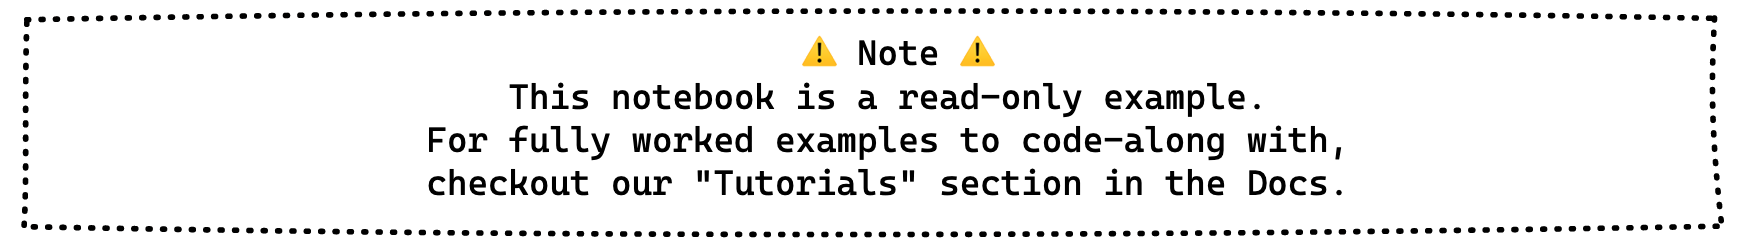

## Zip The [Training Sets]()

Now that we know the features we want to use and the labels for prediction, let's get some training sets up and running that we could use for analysis, forecasting, or clustering.



> *Once we have our features and labels registered, we can create a training set. Training set creation works by joining a label with a set of features via their entity value and timestamp. For each row of the label, the entity value is used to look up all of the feature values in the training set. When a timestamp is included in the label and the feature, the training set will contain the latest feature value where the feature's timestamp is less than the label's.*

### Register Training Set

In [ ]:
ff.register_training_set(
    "fraud_training",
    label=("fraudulent"),
    features=[("avg_transactions")],
)


## Materialize The Definitions He Created via [`apply`](https://docs.featureform.com/getting-started/interact-with-the-cli#apply-command)

We'll now apply the definitions we've created.

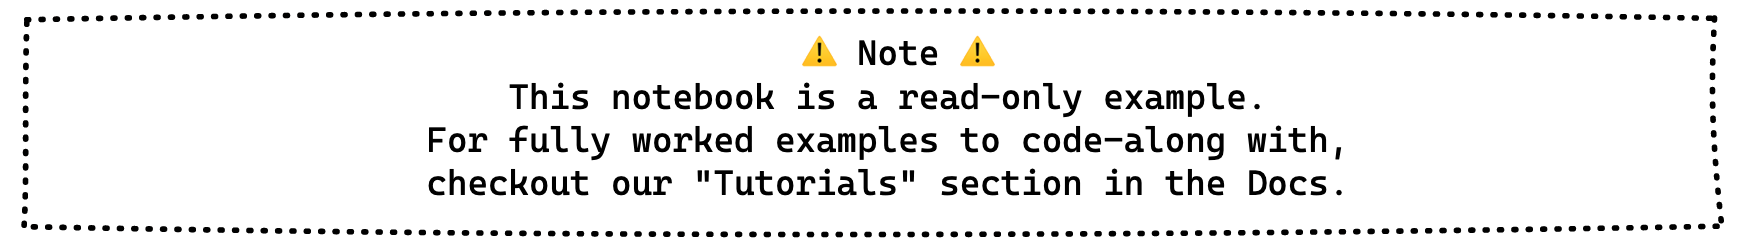

In [ ]:
client = ff.ResourceClient(host=FEATUREFORM_HOST)
client.apply()

# 🚃 [Train a Model With Served Features](https://docs.featureform.com/getting-started/serving-for-inference-and-training) 👩🏻‍🍳

> *Once the training sets and features have been created, they can be served. Featureform provides a Dataset API for training and an Inference API for feature serving.*

💬 When a [training set is defined](https://docs.featureform.com/getting-started/defining-features-labels-and-training-sets#registering-training-sets), it is materialized into the [offline store](https://docs.featureform.com/getting-started/registering-infrastructure-providers#offline-store) associated with the definition. 

## Serving Features from Featureform

In [ ]:
serving = ff.ServingClient(host=FEATUREFORM_HOST)
dataset = serving.training_set("fraud_training", "default")
training_dataset = dataset.repeat(1).shuffle(1000).batch(12)

## Train Model

In [ ]:
from sklearn.linear_model import SGDClassifier

classifier = SGDClassifier(loss='log')
for batch in training_dataset:
  classifier.partial_fit(batch.features(), batch.label(), [True, False])

# Get one batch of training data as sample test data
# Make a test prediction
classifier.predict(batch.features())

array([False, False, False, False])

### Serve Features for Inference

In [ ]:
feature = serving.features(["avg_transaction"], {"user":"C4650842"})


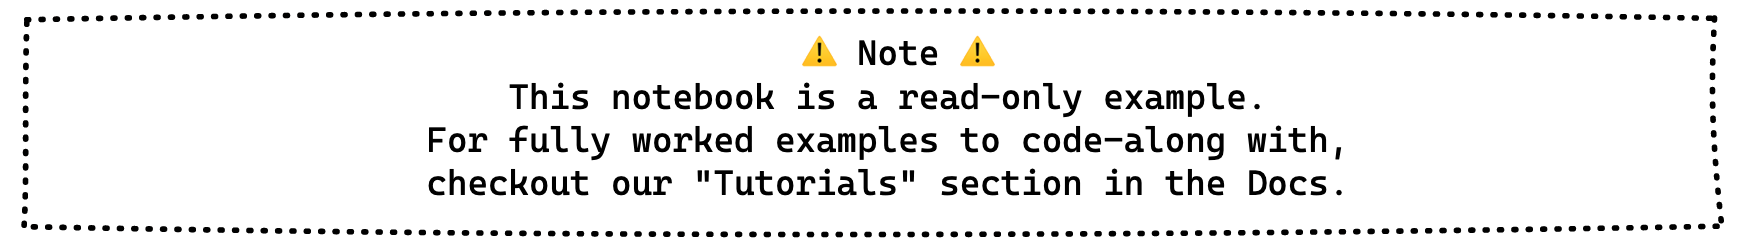